### Imports

In [4]:
import re
import time
import json
import requests as rq
import unidecode

import numpy as np
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_seq_items = 500

from scipy.stats import spearmanr, pearsonr
import warnings
warnings.filterwarnings('ignore')

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.4)

import plotly.offline as offline
import plotly.plotly as py
import plotly.graph_objs as go

offline.init_notebook_mode()

### Google API para lat y lon de aglomerados

In [ ]:
def geodecode(query):
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address='
    headers = {'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Mobile Safari/537.36'}
    q = query.replace(' ', '%20')
    c = rq.get(url+q, headers = headers).content
    data = json.loads(c)
    x, y = data['results'][0]['geometry']['location'].items()
    return (x[1], y[1]) if 'lat' in x else (y[1], x[1])

In [ ]:
s = unidecode.unidecode(""" 02 = Gran La Plata
 03 = Bahía Blanca - Cerri
 04 = Gran Rosario
 05 = Gran Santa Fé
 06 = Gran Paraná
 07 = Posadas
 08 = Gran Resistencia
 09 = Cdro. Rivadavia - R.Tilly
 10 = Gran Mendoza
 12 = Corrientes
 13 = Gran Córdoba
 14 = Concordia
 15 = Formosa
 17 = Neuquén – Plottier
 18 = S.del Estero - La Banda
 19 = Jujuy - Palpalá
 20 = Río Gallegos
 22 = Gran Catamarca
 23 = Salta
 25 = La Rioja
 26 = San Luis - El Chorrillo
 27 = Gran San Juan
 29 = Gran Tucumán - T. Viejo
 30 = Santa Rosa - Toay
 31 = Ushuaia - Río Grande
 32 = Ciudad de Bs As
 33 = Partidos del GBA
 34 = Mar del Plata - Batán
 36 = Río Cuarto
 38 = San Nicolás – Villa Constitución
 91 = Rawson – Trelew
 93 = Viedma – Carmen de Patagones
 """)

In [ ]:
aglomerados = {k:[c] for c, k in re.findall('(\d+)\s=\s([\w\s/./-]+?)\n', s, flags=re.IGNORECASE)}

In [ ]:
coords = 0
while coords < len(aglomerados):
    offset = ' argentina'
    for t in aglomerados.keys():
        if len(aglomerados[t]) == 1:
            try:
                aglomerados[t].extend(geodecode(t + offset))
                coords += 1
                print(t, 'ok')
            except:
                print('err', t)
                offset = ' arg'
            time.sleep(2)

In [ ]:
coords_df = pd.DataFrame.from_dict(aglomerados, orient='index')
coords_df.columns = 'cod, lat, lon'.split(', ')
coords_df['cod'] = coords_df['cod'].apply(pd.to_numeric)

In [ ]:
coords_df.to_json('coord_df.json')

## EPH

In [6]:
coords_df = pd.read_json('coord_df.json')

In [7]:
# https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_2_Trim_2018_txt.zip
fname = './EPH_usu_2_Trim_2018_txt/usu_individual_t218.txt'
df_ = pd.read_table(fname, sep = ';')

In [8]:
df = df_.replace('', np.nan).copy()

In [9]:
df.sample(10)

CODUSU  ANO4  TRIMESTRE  NRO_HOGAR  COMPONENTE  \
55021  TQRMNOQSTHJNKMCDEIOAH00616908  2018          2          1           3   
30870  TQRMNOPRRHKMKTCDEHLEH00608966  2018          2          1           5   
11089  TQRMNOTWXHLLKPCDEFPCH00612881  2018          2          1           3   
40364  TQRMNOQRUHKMKPCDEIHJF00609715  2018          2          1           1   
36858  TQRMNOPRPHKOKNCDEHPJB00609415  2018          2          1           3   
20836  TQRMNORUTHLLKSCDEGNFJ00596755  2018          2          1           2   
50434  TQRMNOQTUHMMRNCDEIJAH00512812  2018          2          1           2   
56304  TQRMNORQVHMNKSCDEOHCH00513842  2018          2          2           2   
25444  TQRMNOQTRHLKKPCDEHGHJ00591442  2018          2          1           1   
31591  TQRMNORYUHJOLQCDEHLEH00614669  2018          2          1           7   

       H15  REGION MAS_500  AGLOMERADO  PONDERA  CH03  CH04        CH05  CH06  \
55021    1      43       N          38       56     3     2  19/08/2005    12   
30870    1      40       N          25      111     3     1  01/01/1900    23   
11089    1      44       N           9      182     3     2  23/05/2002    15   
40364    1      44       N          31      115     1     1  24/05/1996    21   
36858    0      40       S          29      344     3     1  26/05/2014     3   
20836    1      44       N          17      363     2     2  20/07/1974    43   
50434    1       1       S          33     1583     2     2  26/10/1962    55   
56304    0      44       N          91       87     3     1  22/12/2008     9   
25444    1      44       N          20      116     1     1  18/04/1954    64   
31591    0      40       N          25      111     5     1  01/01/1900    -1   

       CH07  CH08  CH09  CH10  CH11  CH12  CH13  CH14  CH15  CH15_COD  CH16  \
55021     5     1     1     1     1     2     2   6.0     1       NaN     1   
30870     5     1     1     1     1     6     2   2.0     3      58.0     1   
11089     5     1     1     1     1     4     2   4.0     1       NaN     1   
40364     5     1     1     2     0     4     1   NaN     3      22.0     1   
36858     5     2     2     3     0     0     0   NaN     1       NaN     6   
20836     2     1     1     2     0     7     1   NaN     3       6.0     1   
50434     2     1     1     1     1     4     2   5.0     1       NaN     1   
56304     5     1     1     1     1     2     2   3.0     1       NaN     1   
25444     2     1     1     2     0     4     2   2.0     3      14.0     1   
31591     5     1     3     0     0     0     0   NaN     1       NaN     6   

       CH16_COD  NIVEL_ED  ESTADO  CAT_OCUP  CAT_INAC  IMPUTA  PP02C1  PP02C2  \
55021       NaN         1       3       0.0         3       0       0       0   
30870       NaN         5       3       0.0         3       0       0       0   
11089       NaN         3       3       0.0         3       0       0       0   
40364       NaN         4       1       3.0         0       0       0       0   
36858       NaN         7       4       0.0         5       0       0       0   
20836       NaN         6       1       3.0         0       0       0       0   
50434       NaN         3       1       3.0         0       0       0       0   
56304       NaN         1       4       0.0         3       0       0       0   
25444       NaN         3       3       0.0         1       0       0       0   
31591       NaN         7       4       0.0         5       0       0       0   

       PP02C3  PP02C4  PP02C5  PP02C6  PP02C7  PP02C8  PP02E  PP02H  PP02I  \
55021       0       0       0       0       0       0      0      2      2   
30870       0       0       0       0       0       0      0      2      2   
11089       0       0       0       0       0       0      0      2      2   
40364       0       0       0       0       0       0      0      0      0   
36858       0       0       0       0       0       0      0      0      0   
20836       0       0      

In [10]:
#¿De qué manera estuvo buscando trabajo?
#Hizo contactos, entrevistas
#PP02C2 N(1)
#PP04G N(2) Dónde realiza principalmente sus tareas?
#PP05E comprar materiales?
#PP06A N(1) En ese negocio/empresa/actividad ¿tiene socios ó
# familiares asociados?
#PP11L N(1) ¿Cuál fue la razón principal por la que dejó esa
# actividad?
#PP11O N(2) ¿Cuál fue la razón principal por la que dejó ese trabajo?

#CH12
discap = 'CAT_INAC'
edu = 'NIVEL_ED'
edad = 'CH06'
parentesco = 'CH03'
analf = 'CH09'
trab = 'ESTADO'
ingresos = 'P47T'
genero = 'CH04'

In [11]:
df['Discapacitado'] = df[discap].apply(lambda x: 1 if x == 6 else 0)

In [12]:
df = df[(df[edad] >= 18) & (df[edad] <= 40)]

In [13]:
df[genero] = df[genero].apply(lambda x: 1 if x == 2 else 0)

In [14]:
# El promedio de edad por aglo es similar. 
edu_aglo = df[df[edu] > 3].groupby('AGLOMERADO').count()[edu] / df.groupby('AGLOMERADO').count()[edu]
coords_df = coords_df.join(edu_aglo, on='cod')

In [15]:
analf_aglo = df[df[analf] == 2].groupby('AGLOMERADO').count()[analf] / df.groupby('AGLOMERADO').count()[analf]
coords_df = coords_df.join(analf_aglo, on='cod')

In [16]:
df[trab] = df[trab].map(lambda x: 1 if x == 2 else 0)

In [17]:
# porcentaje desempleo
desempl_aglo = df.groupby('AGLOMERADO').sum()[trab] /df.groupby('AGLOMERADO').count().iloc[:,0]
coords_df = coords_df.join(desempl_aglo.rename(trab), on='cod')

In [18]:
m = df[ingresos].mean()
sd = df[ingresos].std()
df[ingresos] = df[ingresos].apply(lambda x: x if x < m + 3*sd else m + 3*sd)
df[ingresos] = df[ingresos].apply(lambda x: x if x > m - 3*sd else m - 3*sd)
df[ingresos] = (df[~df[ingresos].isnull()][ingresos] - df[~df[ingresos].isnull()][ingresos].min()) / df[~df[ingresos].isnull()][ingresos].max()
ingresos_aglo = df.groupby('AGLOMERADO')[ingresos].median()
coords_df = coords_df.join(ingresos_aglo.rename(ingresos), on='cod')

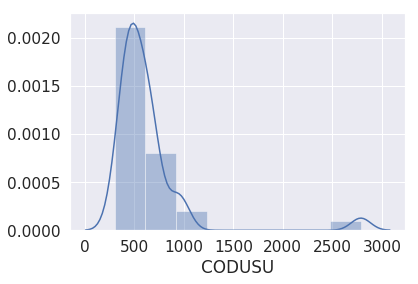

In [19]:
# tamaño de muestra por aglomerado
sns.distplot(df.groupby('AGLOMERADO').count().iloc[:,0]
            .sort_values(), 8);

In [20]:
x, y, z, a, b, c, d, e = 'Desempleo', 'Analfabetismo', 'Nivel educativo', 'Parentesco', 'Edad', 'Ingresos tot', 'Genero', 'p Genero'
coords_df = coords_df.rename({trab:x, analf:y, edu:z, parentesco:a, edad:b, ingresos:c}, axis=1)
df = df.rename({trab:x, analf:y, edu:z, parentesco:a, edad:b, ingresos:c, genero:d}, axis=1)

In [21]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots(1,3,figsize=(13,8), sharey=True)

coords_df.sort_values(x, inplace=True)
sns.barplot(coords_df[x], coords_df.index, palette='Blues', ax=ax[0])
ax[0].set_xlabel(x, fontsize=14)
ax[0].set_yticklabels(ax[0].get_yticklabels());

sns.barplot(coords_df[y], coords_df.index, palette='Blues', ax=ax[1])
ax[1].set_xlabel(y, fontsize=14)

sns.barplot(coords_df[z], coords_df.index, palette='Blues', ax=ax[2])
ax[2].set_xlabel('% secundario incompleto'.format(z), fontsize=14, rotation=0)
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45, fontsize=12)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45, fontsize=12)
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=45, fontsize=12)
plt.subplots_adjust(wspace=0, hspace=0)
sns.despine(left=True)

In [22]:
gen_ing_aglo = df.groupby('AGLOMERADO')[[c, d]].apply(lambda x: pearsonr(x[c], x[d])[0])
coords_df = coords_df.join(gen_ing_aglo.rename('p Genero'), on='cod')

In [23]:
coords_df.sample(5)

cod        lat        lon  Nivel educativo  \
Viedma - Carmen de Patagones   93 -40.798639 -62.980361         0.664336   
Gran Santa Fe                   5 -31.638119 -60.690885         0.692308   
Gran Parana                     6 -31.732356 -60.529623         0.717138   
Partidos del GBA               33 -34.479665 -58.703033         0.627198   
S.del Estero - La Banda        18 -27.361800 -64.242480         0.611852   

                              Analfabetismo  Desempleo  Ingresos tot  p Genero  
Viedma - Carmen de Patagones       0.011655   0.046620      0.069226 -0.110423  
Gran Santa Fe                           NaN   0.062937      0.123960 -0.135517  
Gran Parana                        0.004992   0.044925      0.095404 -0.142633  
Partidos del GBA                   0.004306   0.120919      0.028771 -0.197493  
S.del Estero - La Banda            0.010370   0.029630      0.081125 -0.166812

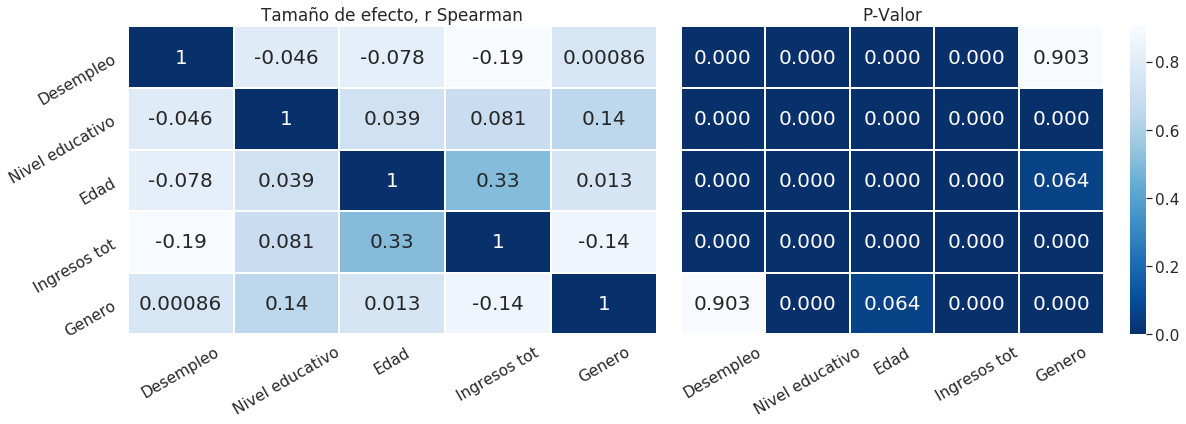

In [24]:
cols = [x, z, b, c, d]

X = df[cols].dropna()

corrs, ps = spearmanr(X.values)

fig, ax = plt.subplots(1,2,figsize=(17,6))

sns.heatmap(corrs, cmap='Blues', ax=ax[0], cbar=False, annot=True, linewidths=1, annot_kws={"size": 20})
ax[0].set_title('Tamaño de efecto, r Spearman')
ax[0].set_yticklabels(cols, rotation=30)
ax[0].set_xticklabels(cols, rotation=30)

sns.heatmap(ps, cmap='Blues_r', ax=ax[1], annot=True, linewidths=1,  fmt='.3f', annot_kws={"size": 20});
ax[1].set_title('P-Valor');
ax[1].set_yticklabels([])
ax[1].set_xticklabels(cols, rotation=30)
plt.tight_layout()

In [25]:
def corrcoef_loop(matrix):
    rows, cols = matrix.shape[0], matrix.shape[1]
    r = np.ones(shape=(rows, rows))
    p = np.ones(shape=(rows, rows))
    for i in range(rows):
        for j in range(i+1, rows):
            r_, p_ = pearsonr(matrix[i], matrix[j])
            r[i, j] = r[j, i] = r_
            p[i, j] = p[j, i] = p_
    return r, p

In [26]:
corrs, ps = corrcoef_loop(X.T.values)

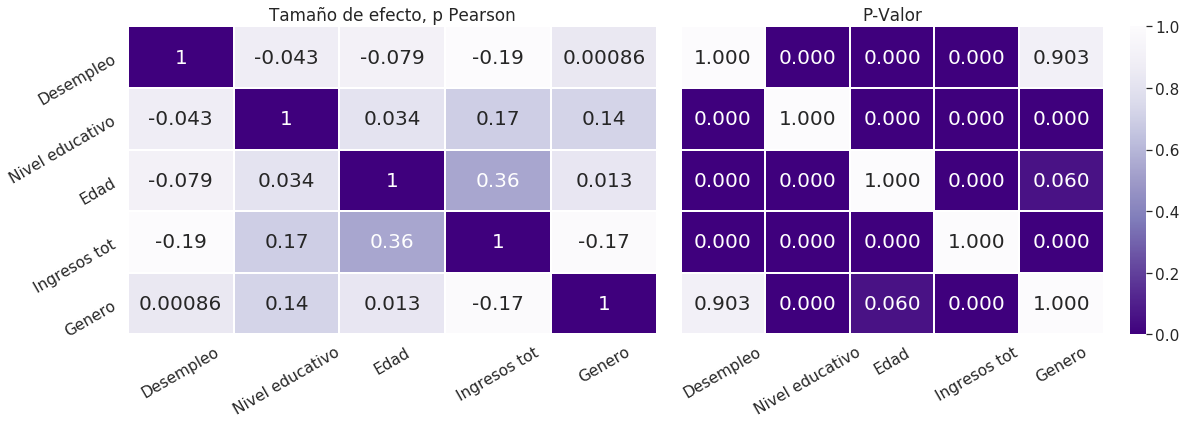

In [27]:
fig, ax = plt.subplots(1,2,figsize=(17,6))

sns.heatmap(corrs, cmap='Purples', ax=ax[0], cbar=False, annot=True, linewidths=1, annot_kws={"size": 20})
ax[0].set_title('Tamaño de efecto, p Pearson')
ax[0].set_yticklabels(cols, rotation=30)
ax[0].set_xticklabels(cols, rotation=30)

sns.heatmap(ps, cmap='Purples_r', ax=ax[1], annot=True, linewidths=1, fmt='.3f',annot_kws={"size": 20});
ax[1].set_title('P-Valor');
ax[1].set_yticklabels([])
ax[1].set_xticklabels(cols, rotation=30)
plt.tight_layout()

In [28]:
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.cluster import dbscan
from sklearn.model_selection import GridSearchCV, train_test_split

In [29]:
df = df.apply(pd.to_numeric, args={'errors':'coerce'})
df = df.dropna(how='all', axis=1)
df = df.fillna(df.median())
df = df.loc[:, ~(df.var() == 0)]

In [30]:
target = 'Desempleo'
#df[target] = df['PP03I'].apply(lambda x: 0 if pd.isnull(x) else 1)
y = df[target]
X = df.drop(target, axis=1)

In [31]:
corrs = X.apply(lambda x: spearmanr(x, y)[0], axis = 0).sort_values()

In [32]:
#X = X.loc[:, corrs[:-10].index]

In [33]:
#X = X.loc[:, :'ITF']
#X = X.loc[:, 'H15':]
#X = X.loc[:, :'Nivel educativo']
#X = X.drop('PONDERA', axis=1)

In [34]:
lasso = LassoCV()
lasso.fit(X, y)
lasso.score(X, y)

0.15556108584653516

In [35]:
X.loc[:, lasso.coef_ > 0].sample(5)

PONDERA  PP06C    PP06D  PP08D1  PP08F1  PP08F2  PP11C  TOT_P12  V3_M  \
29308      213    0.0      0.0     0.0     0.0     0.0    2.0     7500     0   
51219      592    0.0      0.0  8200.0     0.0     0.0    2.0     8000     0   
15497      578    0.0  10000.0     0.0     0.0     0.0    2.0     3000     0   
17387      461    0.0      0.0  8000.0     0.0     0.0    2.0        0     0   
10268      304    0.0      0.0  5000.0     0.0     0.0    2.0        0     0   

       V4_M  PONDIH  
29308     0     237  
51219     0    1247  
15497     0     608  
17387     0     470  
10268     0     301

In [36]:
coefs = pd.DataFrame(t for t in zip(X.columns, lasso.coef_)).set_index(0).unstack() 

In [37]:
coefs[coefs>0]

1  PONDERA    0.000024
   PP06C      0.000024
   PP06D      0.000024
   PP08D1     0.000024
   PP08F1     0.000024
   PP08F2     0.000010
   PP11C      0.000503
   TOT_P12    0.000006
   V3_M       0.000003
   V4_M       0.000017
   PONDIH     0.000009
dtype: float64

In [38]:
#X = X.loc[:, X.columns & pd.Index(False if c.startswith('PP') else True for c in X.columns)]
#X = X.loc[:, (~X.columns.isin(coefs[coefs>0].index.values))]

In [39]:
rf = DecisionTreeClassifier()
rf.fit(X, y)
rf.score(X,y)

1.0

In [40]:
coefs = pd.DataFrame(t for t in zip(X.columns, rf.feature_importances_)).set_index(0)[1]
coefs[coefs>0]

0
PP02C4       0.926171
PP11B_COD    0.004408
PP11C        0.026390
PP11L1       0.043031
Name: 1, dtype: float64

In [41]:
import os     
os.environ["PATH"] += os.pathsep + r'C:\Users\mgrinberg\AppData\Local\Continuum\anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz'

In [42]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(rf, feature_names=X.columns, impurity=False, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

In [43]:
lat = -40
lon= -66
api_k='pk.eyJ1IjoiY2hyaWRkeXAiLCJhIjoiY2lxMnVvdm5iMDA4dnhsbTQ5aHJzcGs0MyJ9.X9o_rzNLNesDxdra4neC_A'

def make_scatter(x, xpad=15, mult=100, colorscale= 'Blues', opacity=0.8):
    return go.Scattermapbox(
            lat = coords_df['lat'],
            lon= coords_df['lon'],
            mode='markers',
            name=x,
            marker=dict(sizemin=6,
                size= abs(coords_df[x]*mult),
                color= coords_df[x],
                colorscale=colorscale,
                opacity=0.8,
                showscale=True,
                reversescale=True,
                colorbar=dict(title=x, 
                              x=1, 
                              xpad=xpad,
                              thickness=20,
                              titleside='right',
                              tickmode='auto',
                              tickangle=45,
                              ),
            ),
            text= coords_df.index.values + 
                '<br> {}: '.format(x) + coords_df[x].apply(lambda x: x).apply('{0:.3f}'.format).astype(str),

            hoverinfo= 'text')

In [51]:
cols = [x,  e]
pads = [15, 100, 190, 280, 370]
mult = [300, 100, 2000, 40, 160, 110]

colors = ['Blues', 
          [[0, 'rgb(150,0,0)'],[0.5, 'rgb(255,100,100)'],
            [1, 'rgb(255,200,200)']],
          [[0, 'rgb(50,120,50)'], [0.5, 'rgb(10,180,60)'],
           [1, 'rgb(210,235,215)']],
          [[0, 'rgb(250,250,0)'], [0.5, 'rgb(250,250,80)'],
                       [1, 'rgb(255,255,240)']], 
         [[0, 'rgb(250,250,250)'], [0.5, 'rgb(125,125,125)'],
                       [1, 'rgb(0,0,0)']]]

data = [make_scatter(*t) for t in zip(cols, pads, mult, colors)]

layout = go.Layout(
    title = 'Indicadores relacionados con el mercado laboral en Argentina',
    autosize=True,
    hovermode='closest',
    legend=dict(x=-.25, y=1),
    mapbox=dict(accesstoken=api_k,
        bearing=0,
        center=dict(
            lat=lat,
            lon=lon
        ),
        pitch=0,
        zoom=3.2,
        style='satellite-streets'
    ),
)

In [52]:
fig = dict( data=data, layout=layout )
offline.iplot(fig, filename='d3-cloropleth-map' )
# https://plot.ly/~Cerebrock/29/